In [1]:
import os
import glob

import pandas as pd
import matplotlib.pyplot as plt

# Local -> all other imports in source files
import settings.custom
from prophandler import PropHandler

from visualizations import prop_ratio
from backup_projections import load_backup_projections, create_historical_props
from private import _load_stokastic_data
from __utils import load_injuries, output_msgs

SITE = "draftkings"
MODE = "classic"
# MODE = 'showdown'

DROP = load_injuries() + []
HISTORICAL = create_historical_props()
BACKUP_EDITS_FILE = '../data/backup_projections.json'
# BACKUP_EDITS_FILE = [
#     '../data/historical/2025-05-14.csv',
#     '../data/historical/2025-05-18.csv'
# ]

# Players who do not currently have props available
# EDITS, OWNERSHIP = load_backup_projections(file=BACKUP_EDITS_FILE), dict()

EDITS, OWNERSHIP = _load_stokastic_data()

# Prop projections always take precedence unless overriden
OVERRIDE_EDITS = {}

In [2]:
df = PropHandler(
    SITE,
    MODE,
    edits=EDITS,
    ownership=OWNERSHIP,
    drop=DROP,
    # override_edits=OVERRIDE_EDITS
).load(
    update=True,
    sort="e_fpts/$",
).reset_index().assign(
    e_ratio=lambda df_: (df_.e_fpts / df_.fpts).round(3),
    # historical=lambda df_: df_.name.map(lambda name_: HISTORICAL.get(name_, 0.0)),
    # hist_diff=lambda df_: df_.fpts-df_.historical,
    # hist_ratio=lambda df_: (df_.fpts/df_.historical).round(2),
    rank=lambda df_: df_.index+1
).set_index('name')



-------------------------------------
PropHandler.load started at: 06:01:16
-------------------------------------
----------------------------------------
Beginning WebScrape of NBA Player Props.
----------------------------------------
Prop projection only: ['Cody Williams', 'Nique Clifford', 'Jordan Clarkson', 'Nolan Traore', 'Andre Drummond', 'Ben Sheppard', 'Egor Demin', "Nae'Qwan Tomlin"]
Biggest movers (fpts):


,pos,salary,team,opp,gametime,fpts,e_fpts,props,fpts/$,e_fpts/$,open,e_open,movement,e_movement
name,,,,,,,,,,,,,,
Kyle Filipowski,PF/C,5400.0,UTA,CHI,"(8, 0)",27.88,13.020,PRA(SBT),5.163,2.411,20.35,10.18,7.53,2.84
Spencer Jones,SF/PF,4800.0,DEN,DAL,"(9, 30)",15.75,7.875,---,3.281,1.641,19.70,9.85,-3.95,-1.97
Ace Bailey,SF,5000.0,UTA,CHI,"(8, 0)",18.62,8.490,PRASB3(T),3.724,1.698,15.38,7.35,3.24,1.14
DeMar DeRozan,SF/PF,7200.0,SAC,NY,"(10, 0)",31.38,15.760,PRASB3(T),4.358,2.189,34.12,16.09,-2.74,-0.33
OG Anunoby,PF,6600.0,NY,SAC,"(10, 0)",27.38,14.640,PRASB3(T),4.148,2.218,29.88,14.69,-2.50,-0.05
Trey Murphy,SG,8000.0,NO,NO,"(8, 0)",36.12,17.630,PRASB3(T),4.515,2.204,38.62,18.18,-2.50,-0.55
Tre Jones,PG,5600.0,CHI,UTA,"(8, 0)",28.47,14.235,---,5.084,2.542,25.99,13.00,2.48,1.23
Jalen Smith,PF/C,5500.0,CHI,UTA,"(8, 0)",26.41,13.205,---,4.802,2.401,23.93,11.96,2.48,1.24
Isaiah Collier,PG,5600.0,UTA,CHI,"(8, 0)",24.31,12.155,---,4.341,2.171,21.96,10.98,2.35,1.17


Biggest movers (e_fpts):


,pos,salary,team,opp,gametime,fpts,e_fpts,props,fpts/$,e_fpts/$,open,e_open,movement,e_movement
name,,,,,,,,,,,,,,
Kyle Filipowski,PF/C,5400.0,UTA,CHI,"(8, 0)",27.88,13.020,PRA(SBT),5.163,2.411,20.35,10.18,7.53,2.84
Spencer Jones,SF/PF,4800.0,DEN,DAL,"(9, 30)",15.75,7.875,---,3.281,1.641,19.70,9.85,-3.95,-1.97
Jamal Shead,PG,4700.0,TOR,IND,"(7, 0)",31.38,15.090,PRASB3(T),6.677,3.211,29.88,13.56,1.50,1.53
Brandon Ingram,SG,7600.0,TOR,IND,"(7, 0)",41.88,20.990,PRASB3(T),5.511,2.762,39.88,19.57,2.00,1.42
Jalen Smith,PF/C,5500.0,CHI,UTA,"(8, 0)",26.41,13.205,---,4.802,2.401,23.93,11.96,2.48,1.24
Tre Jones,PG,5600.0,CHI,UTA,"(8, 0)",28.47,14.235,---,5.084,2.542,25.99,13.00,2.48,1.23
Isaiah Collier,PG,5600.0,UTA,CHI,"(8, 0)",24.31,12.155,---,4.341,2.171,21.96,10.98,2.35,1.17
Scottie Barnes,PF,8500.0,TOR,IND,"(7, 0)",48.62,22.550,PRASB3T,5.720,2.653,47.12,21.38,1.50,1.17
Ace Bailey,SF,5000.0,UTA,CHI,"(8, 0)",18.62,8.490,PRASB3(T),3.724,1.698,15.38,7.35,3.24,1.14


--------------------
14 teams total
Missing: 0% of teams
--------------------
-----------------
112 TOTAL PLAYERS
      num-players
team             
UTA            10
CLE             9
CHI             8
DAL             8
DEN             8
BKN             8
IND             8
PHI             8
SAC             8
NY              8
WAS             8
NO              7
LAC             7
TOR             6
-----------------
---------------------------------------------
Performance time for PropHandler.load: 1m 6s.
---------------------------------------------


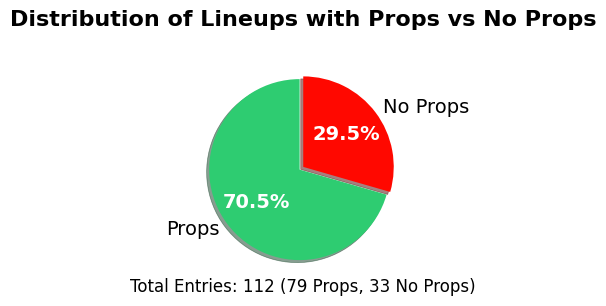

,pos,salary,team,opp,gametime,fpts,e_fpts,props,fpts/$,e_fpts/$,open,e_open,movement,e_movement,own,e_ratio,rank
name,,,,,,,,,,,,,,,,,
Brook Lopez,C,3700.0,LAC,WAS,"(10, 30)",25.92,12.960,---,7.005,3.503,25.92,12.96,0.00,0.00,58.70,0.500,1
Jamal Shead,PG,4700.0,TOR,IND,"(7, 0)",31.38,15.090,PRASB3(T),6.677,3.211,29.88,13.56,1.50,1.53,29.57,0.481,2
Coby White,SG,5800.0,CHI,UTA,"(8, 0)",33.76,16.880,---,5.821,2.910,33.23,16.61,0.53,0.27,54.50,0.500,3
Brandon Ingram,SG,7600.0,TOR,IND,"(7, 0)",41.88,20.990,PRASB3(T),5.511,2.762,39.88,19.57,2.00,1.42,22.47,0.501,4
Collin Murray-Boyles,PF/C,5300.0,TOR,IND,"(7, 0)",29.38,14.400,PRASB3(T),5.543,2.717,28.12,13.80,1.26,0.60,16.93,0.490,5
Scottie Barnes,PF,8500.0,TOR,IND,"(7, 0)",48.62,22.550,PRASB3T,5.720,2.653,47.12,21.38,1.50,1.17,19.87,0.464,6
Jordan Miller,SG/SF,3900.0,LAC,WAS,"(10, 30)",20.45,10.225,---,5.244,2.622,20.45,10.22,0.00,0.00,15.00,0.500,7
Brandon Williams,PG/SG,4800.0,DAL,DEN,"(9, 30)",24.95,12.475,---,5.198,2.599,25.80,12.90,-0.85,-0.43,8.30,0.500,8
John Collins,PF/C,6100.0,LAC,WAS,"(10, 30)",31.63,15.815,---,5.185,2.593,30.09,15.04,1.54,0.78,12.70,0.500,9


In [3]:
if not df.loc[df.props == '---'].empty:
    try:
        fig = prop_ratio(df, cutoff=0.0)
        display(fig)  # Only display once
        plt.close(fig)
    except ValueError:
        print('No props available. Using backup projections for all players.\n')
else:
    output_msgs('All players with props', char='=')

display(df)

In [4]:
team_dfs = {
    team:
    df.loc[df['team'] == team]
    for team in df['team'].drop_duplicates()
}

In [5]:
import numpy as np
# team_dfs[str(np.random.choice(list(team_dfs.keys())))]

#### `handler.constant_scrape()`
##### Repeatedly scrapes props, making sure always as up to date as possible and saving behind the scenes.
##### Caveats include the fact it has an infinite loop built in and that it is pretty useless when it comes to playoffs since books much more on top of lines then.

In [6]:
# df = PropHandler(
#     SITE,
#     MODE,
#     edits=EDITS,
#     drop=DROP,
#     constant=True,
#     # override_edits=OVERRIDE_EDITS
# ).constant_scrape(verbose=0) 